In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, avg

# Khởi tạo SparkSession
spark = SparkSession.builder.appName("CreditCardFraudDetection").getOrCreate()


In [2]:
from datetime import datetime
from pyspark.sql import Row

# Dữ liệu mô phỏng
data = [
    Row(TransactionID=1, Amount=50, Location="New York", IP_Address="192.168.1.1", Timestamp=datetime(2025,1,29,10,0), DeliveryType="Home"),
    Row(TransactionID=2, Amount=5000, Location="Los Angeles", IP_Address="10.0.0.2", Timestamp=datetime(2025,1,29,10,5), DeliveryType="Store Pickup"),
    Row(TransactionID=3, Amount=30, Location="New York", IP_Address="192.168.1.1", Timestamp=datetime(2025,1,29,10,10), DeliveryType="Home"),
    Row(TransactionID=4, Amount=7000, Location="Texas", IP_Address="10.0.0.3", Timestamp=datetime(2025,1,29,10,15), DeliveryType="PO Box"),
    Row(TransactionID=5, Amount=90, Location="Los Angeles", IP_Address="10.0.0.4", Timestamp=datetime(2025,1,29,10,20), DeliveryType="Home"),
    Row(TransactionID=6, Amount=12000, Location="Texas", IP_Address="10.0.0.5", Timestamp=datetime(2025,1,29,10,25), DeliveryType="Store Pickup"),
    Row(TransactionID=7, Amount=4000, Location="Chicago", IP_Address="172.16.0.1", Timestamp=datetime(2025,1,29,10,30), DeliveryType="Home"),
    Row(TransactionID=8, Amount=80, Location="Chicago", IP_Address="172.16.0.1", Timestamp=datetime(2025,1,29,10,35), DeliveryType="Home"),
    Row(TransactionID=9, Amount=200, Location="Miami", IP_Address="8.8.8.8", Timestamp=datetime(2025,1,29,10,40), DeliveryType="Store Pickup"),
    Row(TransactionID=10, Amount=6000, Location="Seattle", IP_Address="8.8.4.4", Timestamp=datetime(2025,1,29,10,45), DeliveryType="Home")
]

# Tạo DataFrame từ dữ liệu
df = spark.createDataFrame(data)

# Hiển thị 5 dòng đầu tiên
df.show()


+-------------+------+-----------+-----------+-------------------+------------+
|TransactionID|Amount|   Location| IP_Address|          Timestamp|DeliveryType|
+-------------+------+-----------+-----------+-------------------+------------+
|            1|    50|   New York|192.168.1.1|2025-01-29 10:00:00|        Home|
|            2|  5000|Los Angeles|   10.0.0.2|2025-01-29 10:05:00|Store Pickup|
|            3|    30|   New York|192.168.1.1|2025-01-29 10:10:00|        Home|
|            4|  7000|      Texas|   10.0.0.3|2025-01-29 10:15:00|      PO Box|
|            5|    90|Los Angeles|   10.0.0.4|2025-01-29 10:20:00|        Home|
|            6| 12000|      Texas|   10.0.0.5|2025-01-29 10:25:00|Store Pickup|
|            7|  4000|    Chicago| 172.16.0.1|2025-01-29 10:30:00|        Home|
|            8|    80|    Chicago| 172.16.0.1|2025-01-29 10:35:00|        Home|
|            9|   200|      Miami|    8.8.8.8|2025-01-29 10:40:00|Store Pickup|
|           10|  6000|    Seattle|    8.

In [23]:
df.agg({"Amount":"avg"}).collect()

[Row(avg(Amount)=3445.0)]

In [8]:
# Tính trung bình số tiền giao dịch
avg_amount = df.agg({"Amount":"avg"}).collect()[0][0] # Collect the average value
print("Trung bình số tiền giao dịch:", avg_amount)

# Xác định giao dịch lớn hơn 2 lần mức trung bình là đáng nghi
suspicious_transactions = df.filter(col("Amount") > (2 * avg_amount))
suspicious_transactions.show()

Trung bình số tiền giao dịch: 3445.0
+-------------+------+--------+----------+-------------------+------------+
|TransactionID|Amount|Location|IP_Address|          Timestamp|DeliveryType|
+-------------+------+--------+----------+-------------------+------------+
|            4|  7000|   Texas|  10.0.0.3|2025-01-29 10:15:00|      PO Box|
|            6| 12000|   Texas|  10.0.0.5|2025-01-29 10:25:00|Store Pickup|
+-------------+------+--------+----------+-------------------+------------+



In [9]:
df.groupBy("IP_Address").agg(count("*").alias("TransactionCount")).orderBy(col("TransactionCount").desc()).show()

+-----------+----------------+
| IP_Address|TransactionCount|
+-----------+----------------+
|192.168.1.1|               2|
| 172.16.0.1|               2|
|   10.0.0.2|               1|
|   10.0.0.3|               1|
|   10.0.0.4|               1|
|   10.0.0.5|               1|
|    8.8.4.4|               1|
|    8.8.8.8|               1|
+-----------+----------------+



In [10]:
df.groupBy("Location").agg(count("*").alias("TransactionCount")).orderBy(col("TransactionCount").desc()).show()

+-----------+----------------+
|   Location|TransactionCount|
+-----------+----------------+
|Los Angeles|               2|
|      Texas|               2|
|   New York|               2|
|    Chicago|               2|
|    Seattle|               1|
|      Miami|               1|
+-----------+----------------+



In [11]:
df.groupBy("DeliveryType").agg(count("*").alias("TransactionCount")).orderBy(col("TransactionCount").desc()).show()

+------------+----------------+
|DeliveryType|TransactionCount|
+------------+----------------+
|        Home|               6|
|Store Pickup|               3|
|      PO Box|               1|
+------------+----------------+



#### Machine Learning Analysis

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Chỉ lấy các cột số để làm input cho mô hình
features = ["Amount"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

df_features = assembler.transform(df)

# Hiển thị dữ liệu đã được vector hóa
df_features.select("features").show(truncate=False)


+---------+
|features |
+---------+
|[50.0]   |
|[5000.0] |
|[30.0]   |
|[7000.0] |
|[90.0]   |
|[12000.0]|
|[4000.0] |
|[80.0]   |
|[200.0]  |
|[6000.0] |
+---------+



In [13]:
# Áp dụng K-Means với 2 cụm (Giao dịch bình thường & Giao dịch đáng ngờ)
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_features)

# Dự đoán cụm cho từng giao dịch
df_clustered = model.transform(df_features)

# Hiển thị kết quả
df_clustered.select("TransactionID", "Amount", "prediction").show()


+-------------+------+----------+
|TransactionID|Amount|prediction|
+-------------+------+----------+
|            1|    50|         1|
|            2|  5000|         1|
|            3|    30|         1|
|            4|  7000|         1|
|            5|    90|         1|
|            6| 12000|         0|
|            7|  4000|         1|
|            8|    80|         1|
|            9|   200|         1|
|           10|  6000|         1|
+-------------+------+----------+



In [14]:
from pyspark.sql.functions import when

df_flagged = df.withColumn("Fraud_Flag",
                           when(col("Amount") > 5000, 1)
                           .when(col("IP_Address") == "8.8.8.8", 1)
                           .otherwise(0))

df_flagged.show()


+-------------+------+-----------+-----------+-------------------+------------+----------+
|TransactionID|Amount|   Location| IP_Address|          Timestamp|DeliveryType|Fraud_Flag|
+-------------+------+-----------+-----------+-------------------+------------+----------+
|            1|    50|   New York|192.168.1.1|2025-01-29 10:00:00|        Home|         0|
|            2|  5000|Los Angeles|   10.0.0.2|2025-01-29 10:05:00|Store Pickup|         0|
|            3|    30|   New York|192.168.1.1|2025-01-29 10:10:00|        Home|         0|
|            4|  7000|      Texas|   10.0.0.3|2025-01-29 10:15:00|      PO Box|         1|
|            5|    90|Los Angeles|   10.0.0.4|2025-01-29 10:20:00|        Home|         0|
|            6| 12000|      Texas|   10.0.0.5|2025-01-29 10:25:00|Store Pickup|         1|
|            7|  4000|    Chicago| 172.16.0.1|2025-01-29 10:30:00|        Home|         0|
|            8|    80|    Chicago| 172.16.0.1|2025-01-29 10:35:00|        Home|         0|

In [15]:
from pyspark.ml.feature import StringIndexer

# Chuyển đổi dữ liệu danh mục (Location, DeliveryType) thành dạng số
indexer = StringIndexer(inputCols=["Location", "DeliveryType"],
                        outputCols=["LocationIndex", "DeliveryTypeIndex"])
df_indexed = indexer.fit(df_flagged).transform(df_flagged)


In [16]:
assembler = VectorAssembler(inputCols=["Amount", "LocationIndex", "DeliveryTypeIndex"],
                            outputCol="features")
df_ml = assembler.transform(df_indexed).select("features", "Fraud_Flag")
df_ml.show()


+-----------------+----------+
|         features|Fraud_Flag|
+-----------------+----------+
|   [50.0,2.0,0.0]|         0|
| [5000.0,1.0,1.0]|         0|
|   [30.0,2.0,0.0]|         0|
| [7000.0,3.0,2.0]|         1|
|   [90.0,1.0,0.0]|         0|
|[12000.0,3.0,1.0]|         1|
| [4000.0,0.0,0.0]|         0|
|   [80.0,0.0,0.0]|         0|
|  [200.0,4.0,1.0]|         1|
| [6000.0,5.0,0.0]|         1|
+-----------------+----------+



In [17]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Tạo mô hình Random Forest
rf = RandomForestClassifier(labelCol="Fraud_Flag", featuresCol="features", numTrees=10)

# Chia dữ liệu thành tập train và test
train_data, test_data = df_ml.randomSplit([0.7, 0.3], seed=42)

# Huấn luyện mô hình
rf_model = rf.fit(train_data)

# Dự đoán trên tập test
predictions = rf_model.transform(test_data)

# Đánh giá mô hình
evaluator = BinaryClassificationEvaluator(labelCol="Fraud_Flag")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.0


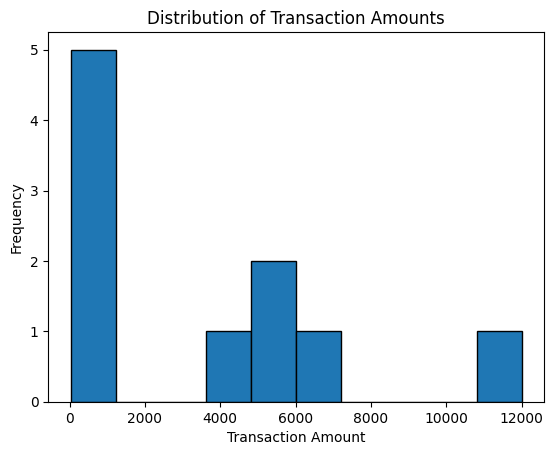

In [18]:
import matplotlib.pyplot as plt

# Trích xuất dữ liệu từ DataFrame
amounts = [row["Amount"] for row in df.collect()]

# Vẽ biểu đồ
plt.hist(amounts, bins=10, edgecolor="black")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Transaction Amounts")
plt.show()
